In [1]:
import numpy as np
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='Parsing.*in DD/MM/YYYY format')
# warnings.filterwarnings('ignore')  # Suppress all warnings

In [ ]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None) # Show full column content

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
amazon_complete = pd.read_csv("amazon_complete.csv")

In [11]:
amazon_complete['year'] = amazon_complete['order_date'].dt.year
rev = amazon_complete.groupby('year')['final_amount_inr'].sum().reset_index()
rev['growth_%'] = rev['final_amount_inr'].pct_change() * 100


In [12]:
rev

,year,final_amount_inr,growth_%
0,2015,2.142163e+09,NaN
1,2016,3.598316e+09,67.975780
2,2017,5.510026e+09,53.127907
3,2018,7.248545e+09,31.551925
4,2019,8.605901e+09,18.725908
5,2020,1.187319e+10,37.965735
6,2021,1.099021e+10,-7.436790
7,2022,8.532312e+09,-22.364427
8,2023,7.712999e+09,-9.602477
9,2024,6.823413e+09,-11.533590


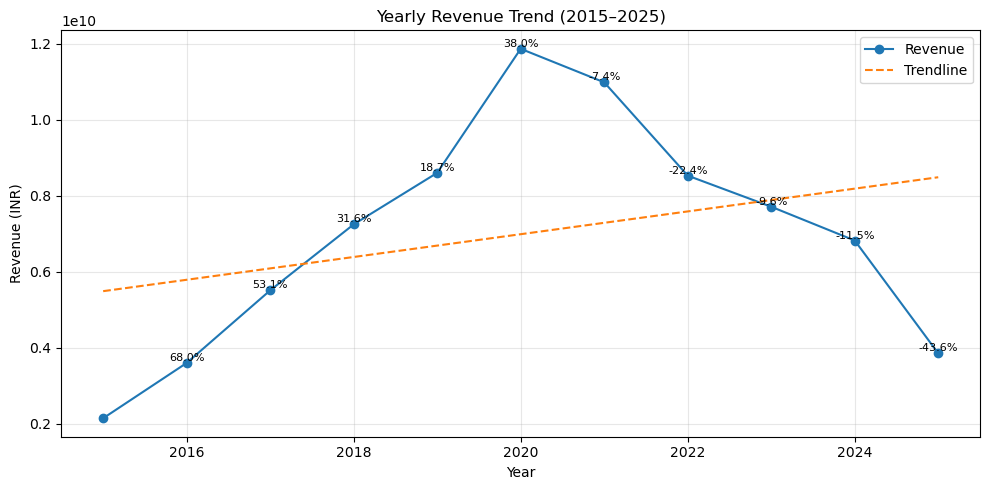

In [ ]:

# Plot
plt.figure(figsize=(10,5))
plt.plot(rev['year'], rev['final_amount_inr'], 'o-', label="Revenue")

z = np.polyfit(rev['year'], rev['final_amount_inr'], 1)
plt.plot(rev['year'], np.poly1d(z)(rev['year']), '--', label="Trendline")

# Annotate growth %
for x, y, g in zip(rev['year'], rev['final_amount_inr'], rev['growth_%']):
    if pd.notna(g):
        plt.text(x, y, f"{g:.1f}%", ha='center', va='bottom', fontsize=8)

plt.title("Yearly Revenue Trend (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Revenue (INR)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### seasonal patterns in sales data

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 0: Define month names for labeling ---
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# --- STEP 1: Prepare Data ---
amazon_complete['order_date'] = pd.to_datetime(amazon_complete['order_date'])
amazon_complete['year'] = amazon_complete['order_date'].dt.year
amazon_complete['month'] = amazon_complete['order_date'].dt.month  # numeric 1-12

# Convert to millions for heatmap
amazon_complete['final_amount_million'] = amazon_complete['final_amount_inr'] / 1_000_000

# --- STEP 2: Monthly Sales Heatmap by Year ---
monthly_sales_pivot = amazon_complete.pivot_table(
    index='month', 
    columns='year', 
    values='final_amount_million', 
    aggfunc='sum'
)


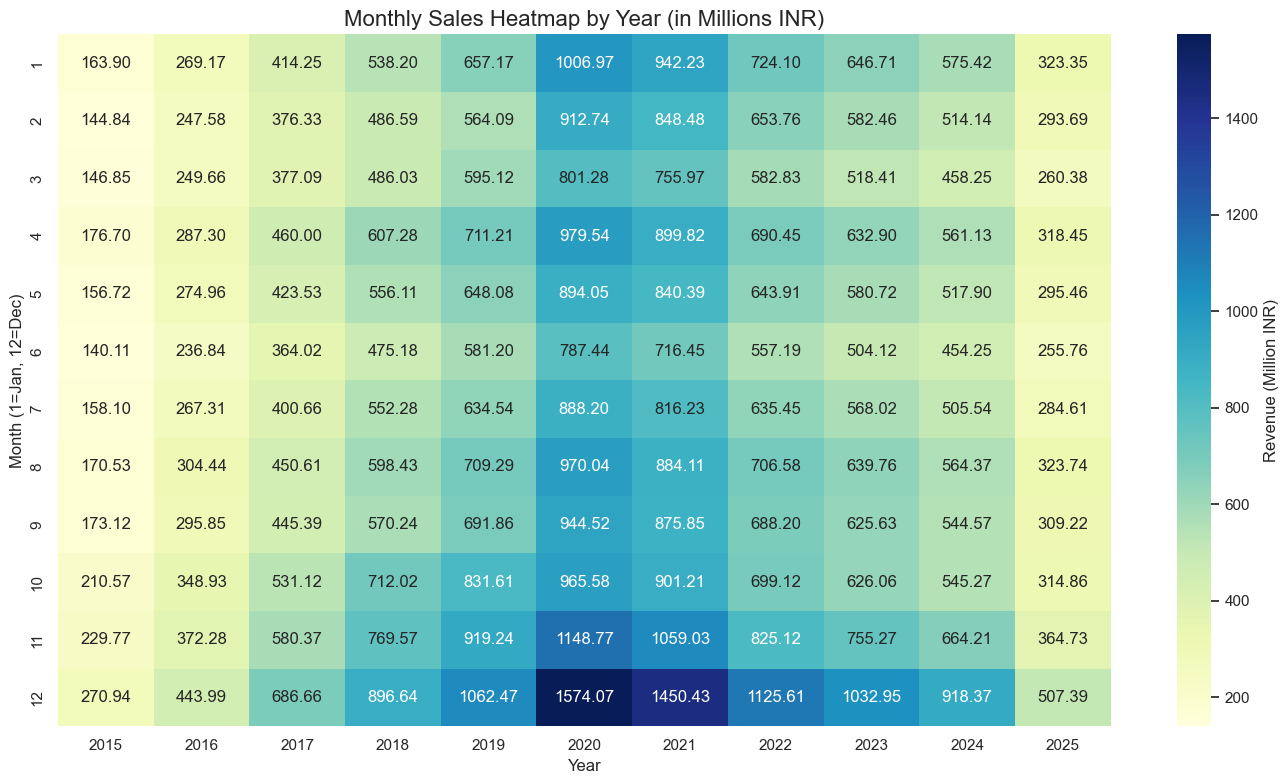

In [33]:
plt.figure(figsize=(14, 8))
sns.heatmap(monthly_sales_pivot, cmap='YlGnBu', annot=True, fmt=".2f", cbar_kws={'label': 'Revenue (Million INR)'})
plt.title("Monthly Sales Heatmap by Year (in Millions INR)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Month (1=Jan, 12=Dec)")
plt.tight_layout()
plt.show()


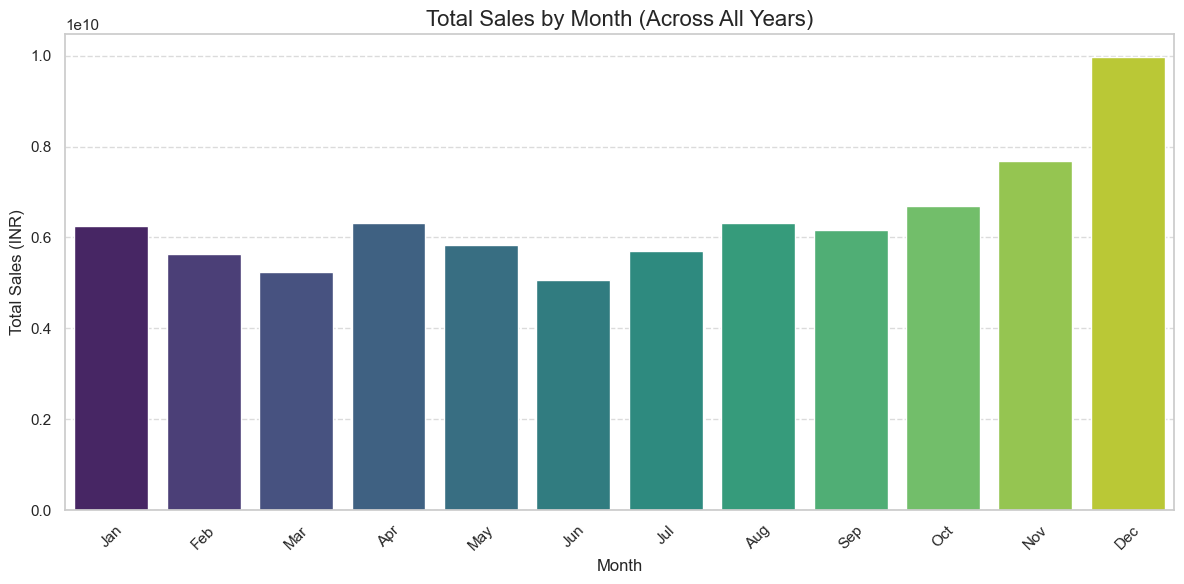

In [34]:
# --- STEP 3: Total Sales by Month (Bar Plot with Month Names) ---
monthly_total = amazon_complete.groupby('month')['final_amount_inr'].sum().reset_index()
monthly_total['month_name'] = monthly_total['month'].map(month_names)

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_total, x='month_name', y='final_amount_inr', palette='viridis')
plt.title('Total Sales by Month (Across All Years)', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Sales (INR)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



📈 OVERALL PEAK SELLING MONTH: Dec with ₹9,969,524,544 in sales


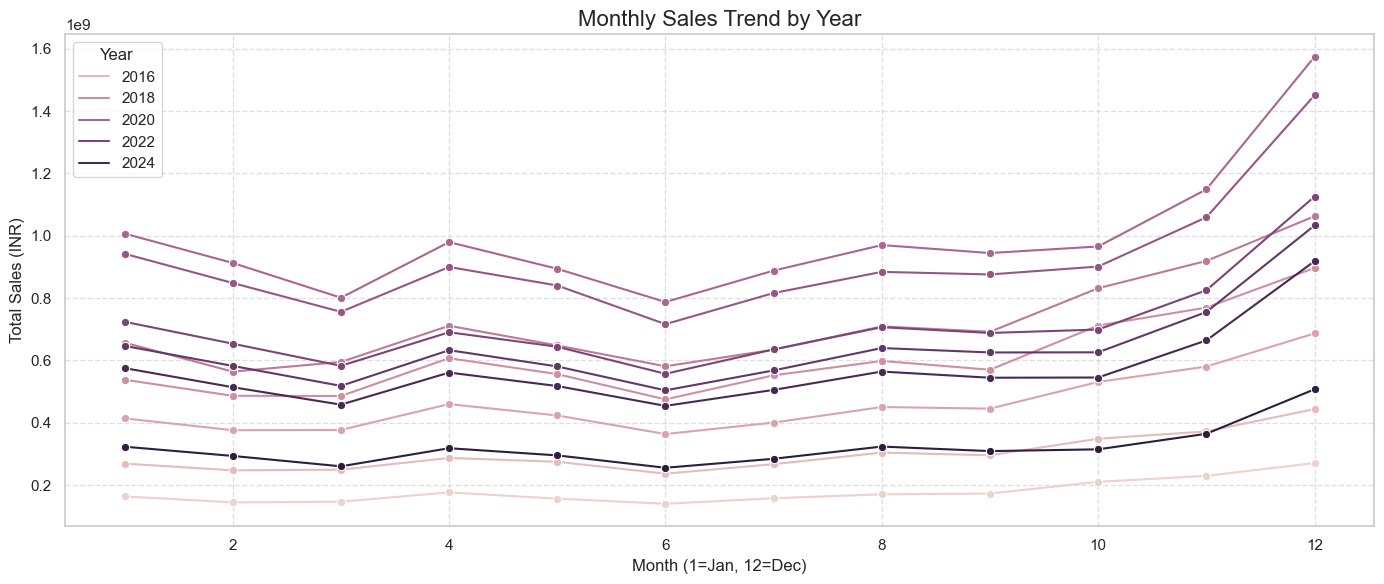

In [35]:
# Identify and print peak month
peak_month = monthly_total.loc[monthly_total['final_amount_inr'].idxmax()]
print(f"\n📈 OVERALL PEAK SELLING MONTH: {peak_month['month_name']} with ₹{peak_month['final_amount_inr']:,.0f} in sales")

# --- STEP 4: Year-over-Year Monthly Trend (Line Plot) ---
year_month_sales = amazon_complete.groupby(['year', 'month'])['final_amount_inr'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=year_month_sales, x='month', y='final_amount_inr', hue='year', marker='o')
plt.title("Monthly Sales Trend by Year", fontsize=16)
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Total Sales (INR)")
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [38]:
# --- STEP 6: Peak Month for Each Category ---
category_peaks = amazon_complete.groupby(['category', 'month'])['final_amount_inr'].sum().reset_index()
idx = category_peaks.groupby('category')['final_amount_inr'].idxmax()
peak_per_category = category_peaks.loc[idx]

print("\n📈 PEAK MONTH BY CATEGORY:")
for _, row in peak_per_category.iterrows():
    month_name = month_names[row['month']]
    print(f"  {row['category']}: {month_name} (₹{row['final_amount_inr']:,.0f})")


📈 PEAK MONTH BY CATEGORY:
  Electronics: Dec (₹9,967,469,459)
  Electronics & Accessories: Aug (₹2,125,436)


### customer segmentation analysis

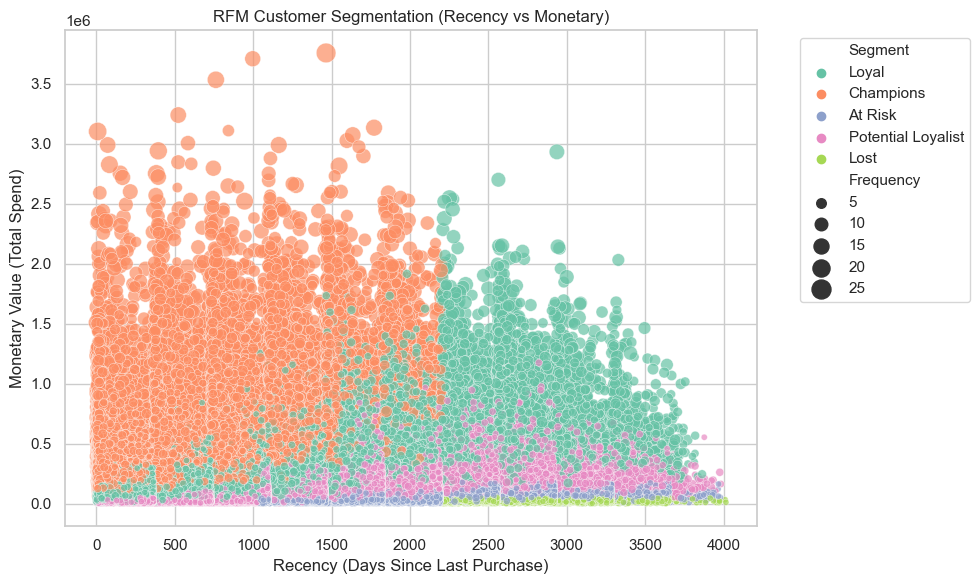

Customer Segment Distribution:
Loyal                 116868
Potential Loyalist    103796
Champions              81996
At Risk                42376
Lost                    9933
Name: Segment, dtype: int64


In [41]:
amazon_complete['order_date'] = pd.to_datetime(amazon_complete['order_date'])

# -------------------------------
# 1. RFM Table Preparation
# -------------------------------
snapshot_date = amazon_complete['order_date'].max() + pd.Timedelta(days=1)

rfm = amazon_complete.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'transaction_id': 'count',                               # Frequency
    'final_amount_inr': 'sum'                                # Monetary
}).reset_index()

rfm.rename(columns={'order_date': 'Recency',
                    'transaction_id': 'Frequency',
                    'final_amount_inr': 'Monetary'}, inplace=True)

# -------------------------------
# 2. Scoring (1-5)
# -------------------------------
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])  # Lower recency = better score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

# -------------------------------
# 3. Define Segments
# -------------------------------
def segment_customer(score):
    if score >= 12:
        return 'Champions'
    elif score >= 9:
        return 'Loyal'
    elif score >= 6:
        return 'Potential Loyalist'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# -------------------------------
# 4. Scatter Plots for Visualization
# -------------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', size='Frequency', hue='Segment', palette='Set2', sizes=(20, 200), alpha=0.7)
plt.title("RFM Customer Segmentation (Recency vs Monetary)")
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Monetary Value (Total Spend)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Segment Counts
# -------------------------------
segment_summary = rfm['Segment'].value_counts()
print("Customer Segment Distribution:")
print(segment_summary)

In [4]:
amazon_complete

,transaction_id,order_date,customer_id,product_id,product_name,category,subcategory,brand,original_price_inr,discount_percent,discounted_price_inr,quantity,subtotal_inr,delivery_charges,final_amount_inr,customer_city,customer_state,customer_tier,customer_spending_tier,customer_age_group,payment_method,delivery_days,delivery_type,is_prime_member,is_festival_sale,festival_name,customer_rating,return_status,order_month,order_year,order_quarter,product_weight_kg,is_prime_eligible,product_rating,is_duplicate,duplicate_type,price_outlier_IQR,price_outlier_3_sigma
0,TXN_2023_00063013,2023-07-23,CUST_2023_00018393,PROD_000454,Vivo Y95 64GB Black,Electronics,Smartphones,Vivo,27340.84,21.57,21442.59,1,21442.59,0.0,21442.59,Kolkata,West Bengal,Metro,Standard,36-45,NaN,3,Standard,False,False,NaN,4.0,Delivered,7,2023,3,0.20,True,3.5,False,NaN,False,False
1,TXN_2021_00064486,2021-07-20,CUST_2015_00002865,PROD_000579,Realme Realme 3 128GB Black,Electronics,Smartphones,Realme,32907.49,0.00,32907.49,3,98722.47,0.0,98722.47,Ludhiana,Punjab,Tier2,Standard,NaN,UPI,3,Standard,False,False,NaN,5.0,Delivered,7,2021,3,0.21,False,4.5,False,NaN,False,False
2,TXN_2017_00065617,2017-11-16,CUST_2016_00004057,PROD_000295,Vivo V7 32GB Blue,Electronics,Smartphones,Vivo,47052.18,21.91,36741.38,1,36741.38,0.0,36741.38,Bengaluru,Karnataka,Metro,Premium,36-45,Debit Card,6,Standard,False,False,NaN,5.0,Delivered,11,2017,4,0.24,True,4.3,False,NaN,False,False
3,TXN_2020_00054393,2020-05-04,CUST_2020_00014574,PROD_001654,Alienware Pavilion 4GB RAM Silver,Electronics,Laptops,Alienware,238725.44,59.60,96456.27,1,96456.27,0.0,96456.27,Bengaluru,Karnataka,Metro,Premium,46-55,UPI,3,Standard,False,True,Summer Sale,5.0,Delivered,5,2020,2,1.85,True,3.6,False,NaN,False,False
4,TXN_2018_00071646,2018-10-09,CUST_2018_00006275,PROD_000095,Motorola Moto X Play 16GB White,Electronics,Smartphones,Motorola,25970.76,0.00,25970.76,1,25970.76,0.0,25970.76,Kochi,Kerala,Tier2,Standard,18-25,NaN,4,Standard,False,False,NaN,4.0,Delivered,10,2018,4,0.16,False,3.7,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127604,TXN_2018_00047331,2018-07-06,CUST_2017_00025689,PROD_000009,Apple iPhone 6 Plus 16GB Black,Electronics,Smartphones,Apple,134278.16,30.83,92886.49,1,92886.49,0.0,92886.49,Jaipur,Rajasthan,Tier1,Standard,26-35,Debit Card,4,Standard,False,True,Back to School,5.0,Delivered,7,2018,3,0.17,True,3.6,False,NaN,False,False
1127605,TXN_2022_00065321,2022-07-23,CUST_2021_00026763,PROD_001732,OnePlus iPad 8GB RAM Silver,Electronics,Tablets,OnePlus,97578.76,0.00,97578.76,1,97578.76,0.0,97578.76,Delhi,Delhi,Metro,Premium,36-45,UPI,1,Same Day,True,False,NaN,4.5,Delivered,7,2022,3,0.58,True,4.6,False,NaN,False,False
1127606,TXN_2023_00057908,2023-01-07,CUST_2023_00031035,PROD_001572,ASUS Inspiron 8GB RAM Black,Electronics,Laptops,ASUS,105284.29,43.31,59683.64,1,59683.64,0.0,59683.64,Bhubaneswar,Odisha,Tier2,Standard,26-35,Debit Card,1,Same Day,True,True,Back to School,4.0,Delivered,7,2023,3,1.37,True,4.2,False,NaN,False,False
1127607,TXN_2020_00035169,2020-04-12,CUST_2017_00005760,PROD_001582,ASUS Gaming 8GB RAM Silver,Electronics,Laptops,ASUS,72687.00,0.00,72686.89,1,72686.89,0.0,72686.89,Mumbai,Maharashtra,Metro,Budget,26-35,NaN,4,Standard,False,False,NaN,5.0,Delivered,4,2020,2,2.02,False,3.8,False,NaN,False,False


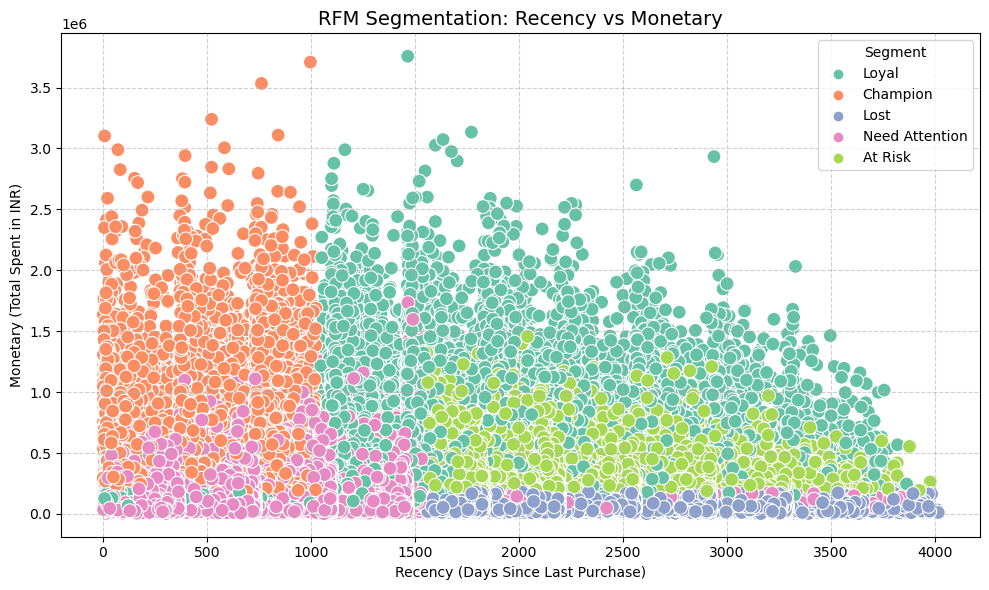


📊 Customer Segments:
Need Attention    128535
Loyal             100963
Lost               60333
Champion           41025
At Risk            24113

💡 Actionable Insights:
🟢 Champions → Reward, upsell, ask for referrals
🟡 Loyal → Keep engaged with loyalty perks
🔵 At Risk → Win back with discounts or emails
🔴 Lost → Low priority, or run reactivation campaign
🟠 Need Attention → Study behavior, personalize offers


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: Prepare RFM Data ---
amazon_complete['order_date'] = pd.to_datetime(amazon_complete['order_date'])
latest_date = amazon_complete['order_date'].max() + pd.Timedelta(days=1)

rfm = amazon_complete.groupby('customer_id').agg(
    recency=('order_date', lambda x: (latest_date - x.max()).days),
    frequency=('transaction_id', 'count'),
    monetary=('final_amount_inr', 'sum')
).reset_index()

# --- STEP 2: Score RFM (1-5 scale) — SAFE VERSION ---
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1], duplicates='drop')
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5], duplicates='drop')

# Fill any missing scores (if too few unique values)
rfm[['r_score','f_score','m_score']] = rfm[['r_score','f_score','m_score']].fillna(3).astype(int)

# Total RFM score
rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

# --- STEP 3: Segment Customers ---
def get_segment(row):
    if row['r_score'] >= 4 and row['f_score'] >= 4 and row['m_score'] >= 4:
        return 'Champion'
    elif row['f_score'] >= 4:
        return 'Loyal'
    elif row['r_score'] <= 2 and row['m_score'] >= 4:
        return 'At Risk'
    elif row['r_score'] <= 2 and row['f_score'] <= 2:
        return 'Lost'
    else:
        return 'Need Attention'

rfm['segment'] = rfm.apply(get_segment, axis=1)



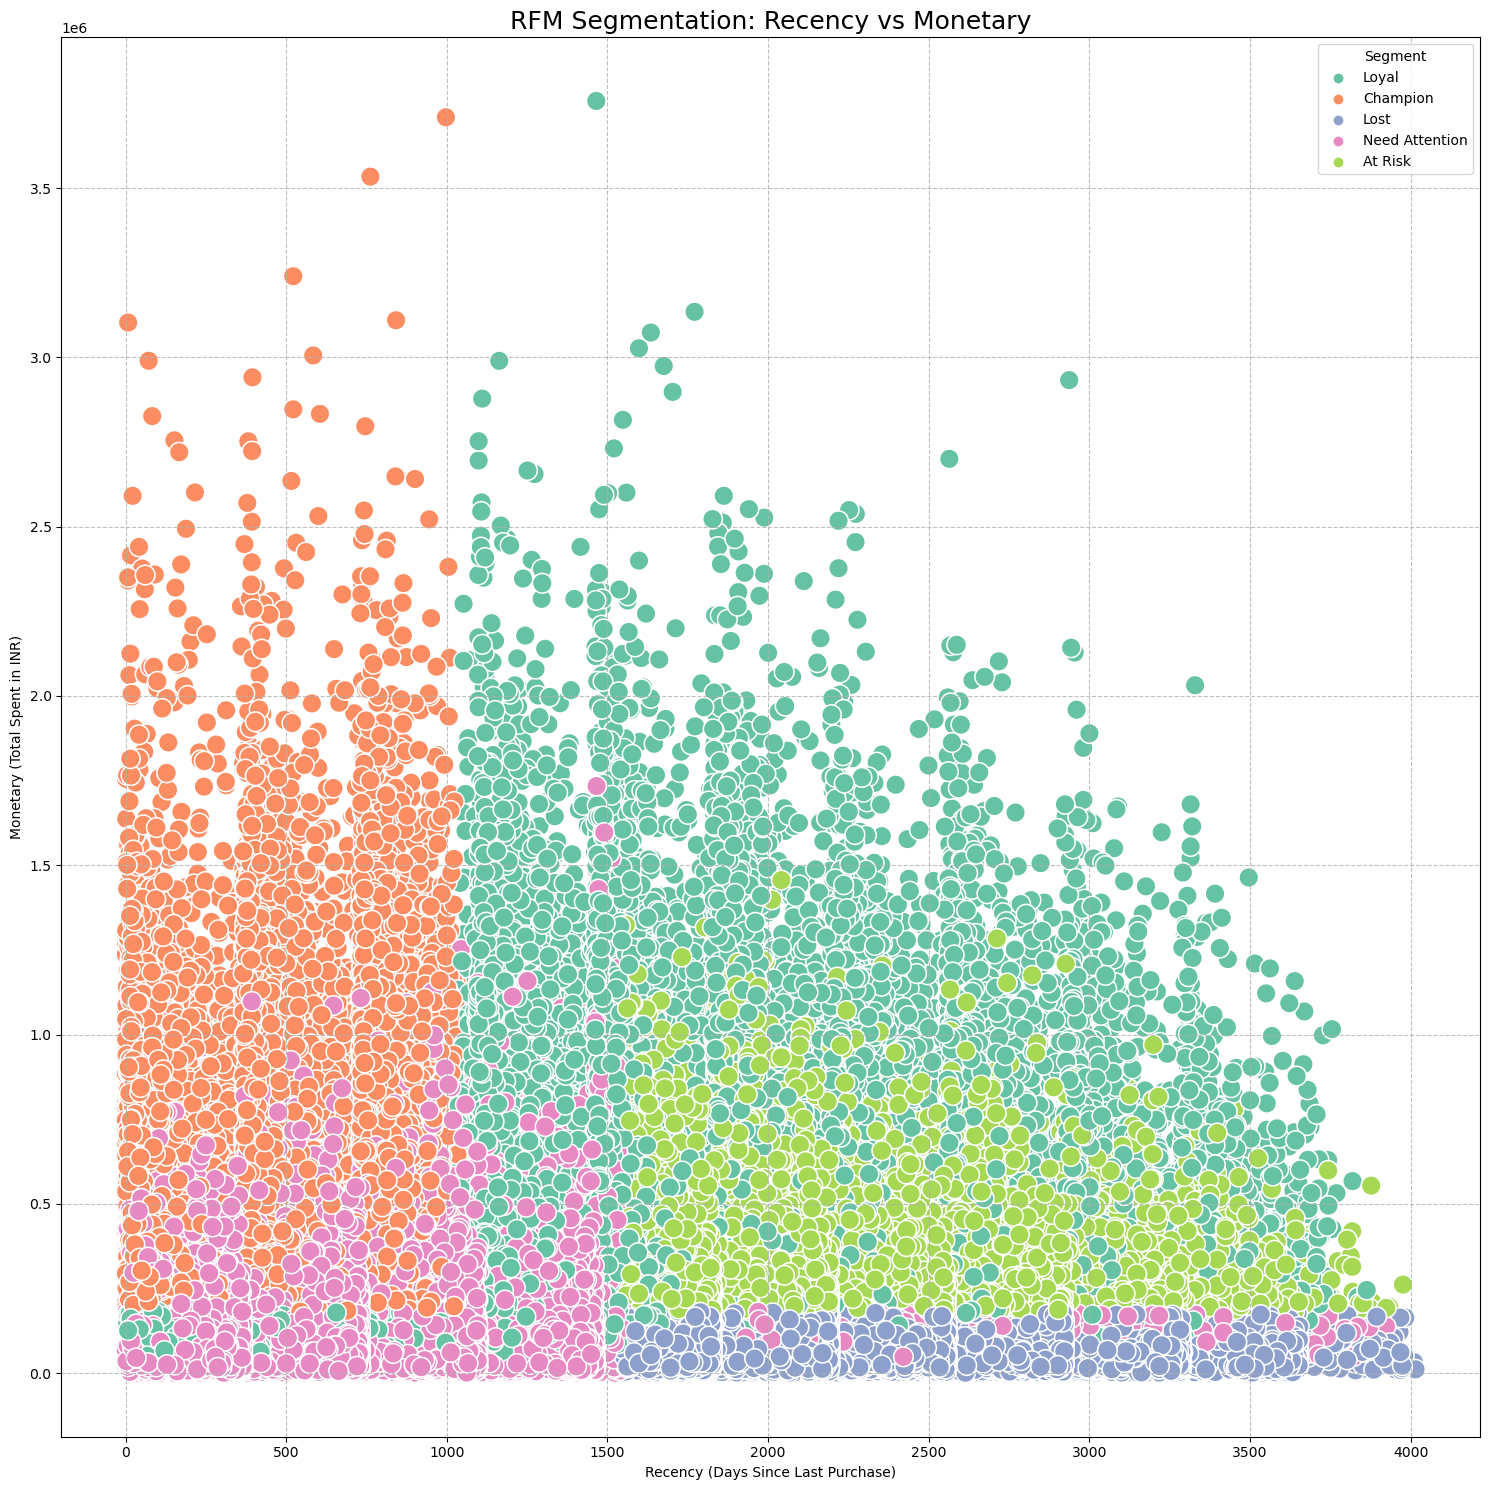


📊 Customer Segments:
Need Attention    128535
Loyal             100963
Lost               60333
Champion           41025
At Risk            24113

💡 Actionable Insights:
🟢 Champions → Reward, upsell, ask for referrals
🟡 Loyal → Keep engaged with loyalty perks
🔵 At Risk → Win back with discounts or emails
🔴 Lost → Low priority, or run reactivation campaign
🟠 Need Attention → Study behavior, personalize offers


In [51]:
# --- STEP 4: Visualize (Recency vs Monetary) ---
plt.figure(figsize=(15,15))
sns.scatterplot(data=rfm, x='recency', y='monetary', hue='segment', s=200, palette='Set2')
plt.title("RFM Segmentation: Recency vs Monetary", fontsize=18)
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Monetary (Total Spent in INR)")
plt.legend(title='Segment')
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

# --- STEP 5: Show Results & Insights ---
print("\n📊 Customer Segments:")
print(rfm['segment'].value_counts().to_string())

print("\n💡 Actionable Insights:")
print("🟢 Champions → Reward, upsell, ask for referrals")
print("🟡 Loyal → Keep engaged with loyalty perks")
print("🔵 At Risk → Win back with discounts or emails")
print("🔴 Lost → Low priority, or run reactivation campaign")
print("🟠 Need Attention → Study behavior, personalize offers")

### evolution of payment

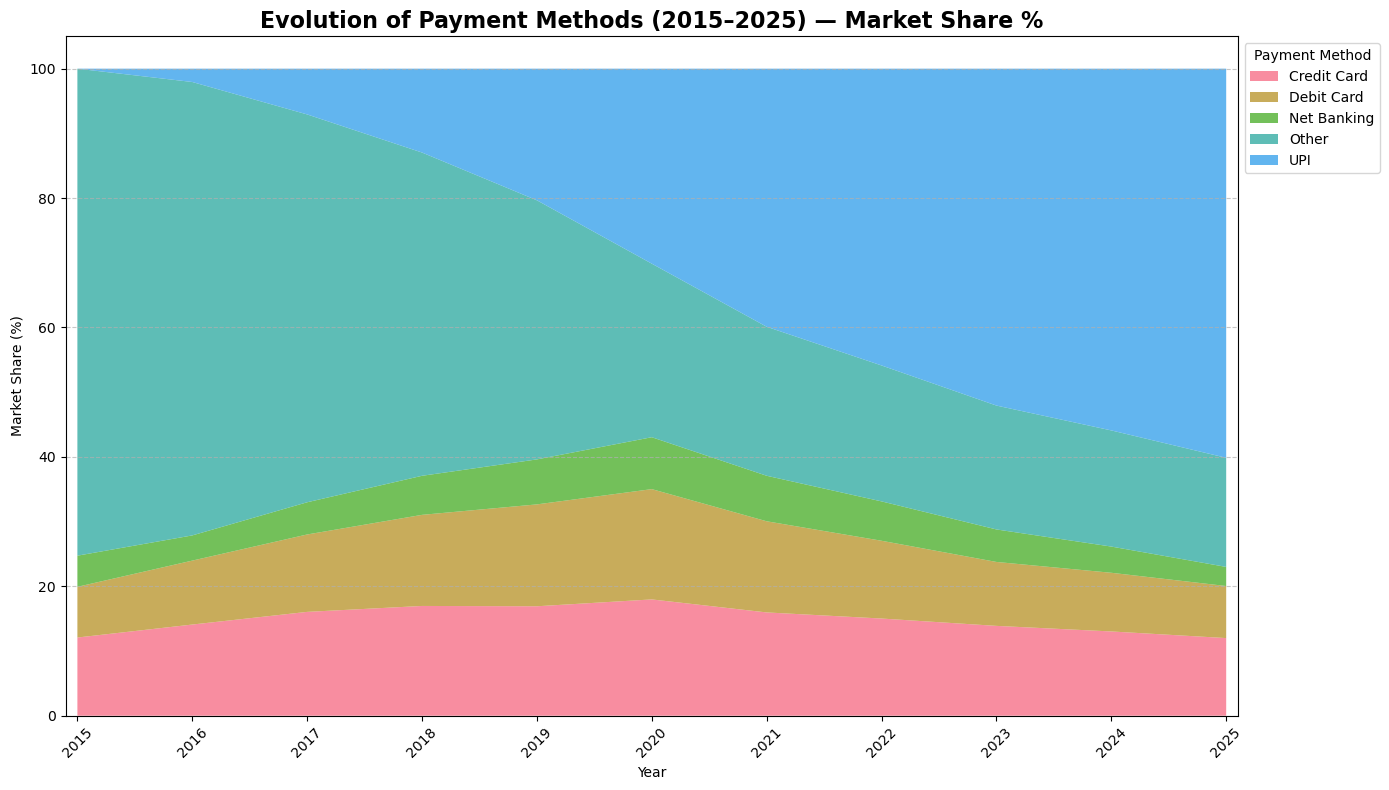


📈 Key Payment Method Trends (2015–2025):
--------------------------------------------------
🚀 UPI: 0.0% → 60.1%

🏆 Dominant Payment Method by Year:
  2015: Other (75.3%)
  2016: Other (70.1%)
  2017: Other (59.9%)
  2018: Other (50.0%)
  2019: Other (40.0%)
  2020: UPI (30.1%)
  2021: UPI (39.9%)
  2022: UPI (45.9%)
  2023: UPI (52.1%)
  2024: UPI (55.9%)
  2025: UPI (60.1%)


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: Prepare Data ---
amazon_complete['order_date'] = pd.to_datetime(amazon_complete['order_date'])
amazon_complete['year'] = amazon_complete['order_date'].dt.year

# Focus on key payment methods (add more if needed)
focus_methods = ['UPI', 'Cash on Delivery', 'Debit Card', 'Credit Card', 'Net Banking']
amazon_complete['payment_method'] = amazon_complete['payment_method'].fillna('Other')
amazon_complete['payment_method'] = amazon_complete['payment_method'].apply(
    lambda x: x if x in focus_methods else 'Other'
)

# --- STEP 2: Calculate Market Share by Year (2015-2025) ---
years = list(range(2015, 2026))
payment_trend = amazon_complete.groupby(['year', 'payment_method']).size().unstack(fill_value=0)

# Reindex to include all years (even with 0 transactions)
payment_trend = payment_trend.reindex(years, fill_value=0)

# Calculate percentage share per year
payment_share = payment_trend.div(payment_trend.sum(axis=1), axis=0) * 100

# --- STEP 3: Plot Stacked Area Chart ---
plt.figure(figsize=(14, 8))
plt.stackplot(payment_share.index, 
              *[payment_share[col] for col in payment_share.columns],
              labels=payment_share.columns,
              alpha=0.8)

plt.title("Evolution of Payment Methods (2015–2025) — Market Share %", fontsize=16, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.legend(title="Payment Method", loc='upper left', bbox_to_anchor=(1,1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(years, rotation=45)
plt.margins(x=0.01)
plt.tight_layout()
plt.show()

# --- STEP 4: Print Key Trends ---
print("\n📈 Key Payment Method Trends (2015–2025):")
print("-" * 50)

# UPI Growth
if 'UPI' in payment_share.columns:
    upi_2015 = payment_share.loc[2015, 'UPI'] if 2015 in payment_share.index else 0
    upi_2025 = payment_share.loc[2025, 'UPI'] if 2025 in payment_share.index else 0
    print(f"🚀 UPI: {upi_2015:.1f}% → {upi_2025:.1f}%")

# COD Decline
if 'Cash on Delivery' in payment_share.columns:
    cod_2015 = payment_share.loc[2015, 'Cash on Delivery'] if 2015 in payment_share.index else 0
    cod_2025 = payment_share.loc[2025, 'Cash on Delivery'] if 2025 in payment_share.index else 0
    print(f"📉 COD: {cod_2015:.1f}% → {cod_2025:.1f}%")

# Optional: Show top method each year
print("\n🏆 Dominant Payment Method by Year:")
for year in years:
    if year in payment_share.index and payment_share.loc[year].sum() > 0:
        top_method = payment_share.loc[year].idxmax()
        share = payment_share.loc[year, top_method]
        print(f"  {year}: {top_method} ({share:.1f}%)")

<Figure size 1200x700 with 0 Axes>

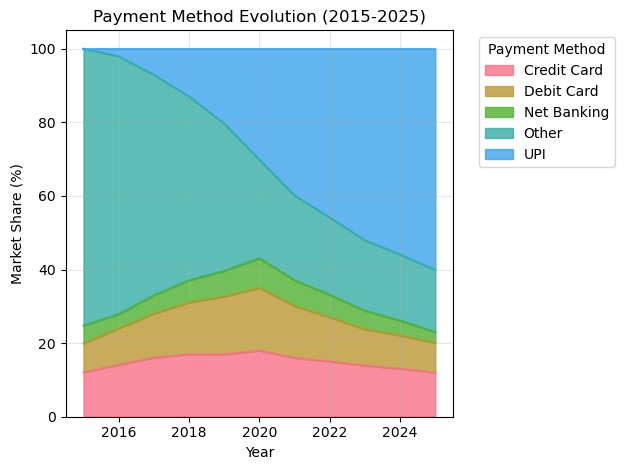

KeyError: 'COD'

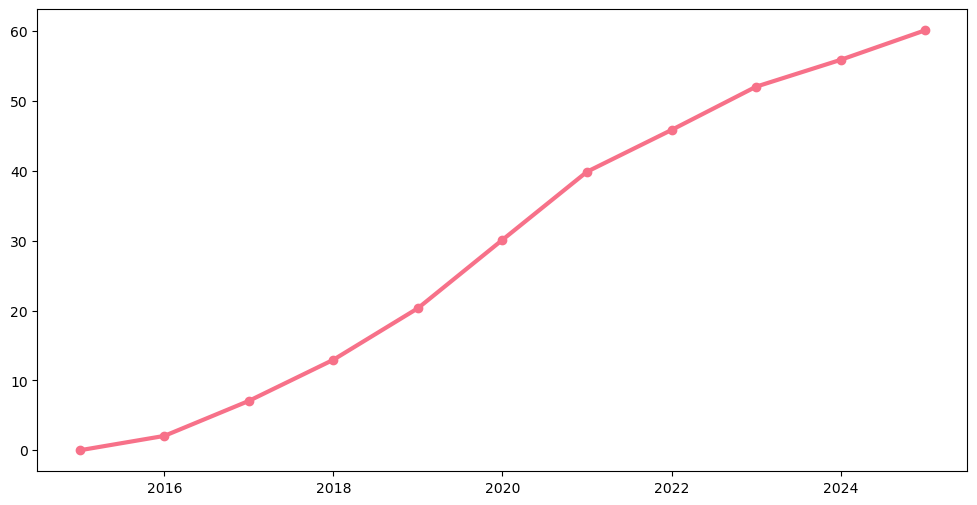

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

amazon_complete['order_date'] = pd.to_datetime(amazon_complete['order_date'])
amazon_complete['order_year'] = amazon_complete['order_date'].dt.year

# Clean payment method names
payment_mapping = {
    'UPI': 'UPI',
    'upi': 'UPI',
    'COD': 'COD',
    'Cod': 'COD',
    'Debit Card': 'Debit Card',
    'Credit Card': 'Credit Card',
    'Net Banking': 'Net Banking',
    'Wallet': 'Digital Wallet'
}

amazon_complete['payment_clean'] = amazon_complete['payment_method'].map(payment_mapping)
amazon_complete['payment_clean'] = amazon_complete['payment_clean'].fillna('Other')

# Group by year and payment method
payment_yearly = amazon_complete.groupby(['order_year', 'payment_clean']).size().unstack(fill_value=0)

# Calculate percentages
payment_percent = payment_yearly.div(payment_yearly.sum(axis=1), axis=0) * 100

# Plot stacked area chart
plt.figure(figsize=(12, 7))
payment_percent.plot.area(stacked=True, alpha=0.8)
plt.title('Payment Method Evolution (2015-2025)')
plt.xlabel('Year')
plt.ylabel('Market Share (%)')
plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot UPI vs COD trend
plt.figure(figsize=(12, 6))
plt.plot(payment_percent.index, payment_percent['UPI'], marker='o', label='UPI', linewidth=3)
plt.plot(payment_percent.index, payment_percent['COD'], marker='s', label='COD', linewidth=3)
plt.title('UPI vs COD Trend')
plt.xlabel('Year')
plt.ylabel('Market Share (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary
print("Payment Method Evolution Summary:")
print(payment_percent.round(1))